# Preprocessing pipeline from raw audio to Mel-spectrograms

In this Notebook we will create a pipeline of mel spectrograms creation. Our starting point is downloading the appropriate languges from:

- Common Voice: https://commonvoice.mozilla.org/en/datasets

After extracting the raw audio clips of 5 seconds, we need to transform them into mel spectrograms. The parameters of the spectrograms ( Time Window of the STFT, Hop size, Number of Mel Frequency bins and the 0 dB reference ) are crucial for our models to correctly function and encode to the latent space.

In addition to the "Vanilla" Mel Spectrograms, we would like to cotrol frequency filtering and how much noise we can intriduce to the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

#import torch    #to save in tensor form
from tqdm import tqdm
import librosa
import librosa.display
from scipy.signal import butter, filtfilt

import os
from glob import glob

In [10]:
# This path variable will create a list with all the clips paths inside the apropriate language folder
ita_path = glob(r'Neuro/data/jap/ja/clips/*')

# Lets see how many clips are into the folder
print(len(ita_path))

41320


In [5]:
def create_mels(folder,                 # Pass the folder path
                output,                 # "directory" outputs all files in a new folder - "dataset"                         outputs a numpy dataset
                language,
                n_mels = 128,
                sample_sec_legth = 5,
                filter = False,         #choose if filter the spectrogram
                cut_off=500,            #threshold value of frequency to keep if filter true
                freq_filt = [0,22000],
                sr = 22050,             # If sr = None it will preserve the native sampling rate
                n_fft = 2048,
                hop_length = 512,
                win_length = None,
                ref = np.min):          #ref can be np.min, np.max, 1 


    """Create the folder in which we are going to save the np.arrays"""
    if output == "directory" :
        folder_name = language+"_mel_spectrograms"
        os.makedirs(folder_name)
        
    #Keep this counter to enumerate files
    i = 0
    #Progress bar
    total_iterations = len(folder)
    #Keep this list to create the dataset, if specified
    dataset = []
    
    for path in tqdm(folder):
        
        """" Load the raw audio, sr = None will preserve the original sampling rate """
        y , sr = librosa.load( path = path,
                                      sr = sr,
                                      mono = True,
                                      offset = 0.0,
                                      duration = None )
        
        """"Fix the length an array data to exactly size along a target axis. 
        If data.shape[axis] < n, pad according to the provided kwargs. By default, 
        data is padded with trailing zeros."""
        
        y = librosa.util.fix_length( y , size = sample_sec_legth * sr )

        if filter:
            # Apply low-pass filter
            cutoff_freq = cut_off  # Cut-off frequency in Hz
            nyquist = 0.5 * sr
            normalized_cutoff = cutoff_freq / nyquist

            # Design the filter
            b, a = butter(4, normalized_cutoff, btype='low', analog=False)

            # Apply the filter to the audio signal
            y = filtfilt(b, a, y)
        

        

        
        #https://librosa.org/doc/main/generated/librosa.stft.html#librosa.stft
    
        S = librosa.feature.melspectrogram(y=y,                    #The timeseries stored in y is passed to create the Mel Spectrogram
                                           sr=sr,                  #The sampling rate.   
                                           n_mels=n_mels,          #Number of Mel bands
                                           win_length=win_length,  #If unspecified, defaults to win_length = n_fft.
                                           hop_length=hop_length,  #If unspecified, defaults to win_length // 4
                                           n_fft=n_fft,            #from librosa.stft - https://librosa.org/doc/main/generated/librosa.stft.html#librosa.stft
                                           fmin=freq_filt[0],      #lowest frequency (in Hz)
                                           fmax=freq_filt[1])      #highest frequency (in Hz).If None, use fmax = sr / 2.0

        """ Convert the Mel Spectrogram (S) from amplitude to Decibel scale
        https://librosa.org/doc/main/generated/librosa.amplitude_to_db.html """
        
        S_db = librosa.amplitude_to_db(S = S , 
                                       ref = ref ) #ref can be np.min, np.max, 1
                                       #top_db = threshold the output at top_db below the peak:  
        """Depending on what we specified the function will behave accordingly"""
        
        if output == "directory" :
            np.save(f'{folder_name}/{language}_mel_spec_{i}.npy', S_db)
            i += 1
        if output == "dataset" :
            dataset.append(S_db)
        if output == "pytorch" :
            torch.save(torch.tensor(S_db),f'{folder_name}/mel_spec{i}{x}.pt')



    if output == "dataset" :
            return(dataset)

In [11]:
create_mels(folder = ita_path[1000:2000],   
            output = "directory", language = "jap_filter",
            n_mels = 128, 
            sample_sec_legth = 5,
            freq_filt = [0,None],
            filter = True,    #filter = true per filtrare e imposta il cutoff
            cut_off=500,   #
            bar=False
            
            )

100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 74.80it/s]


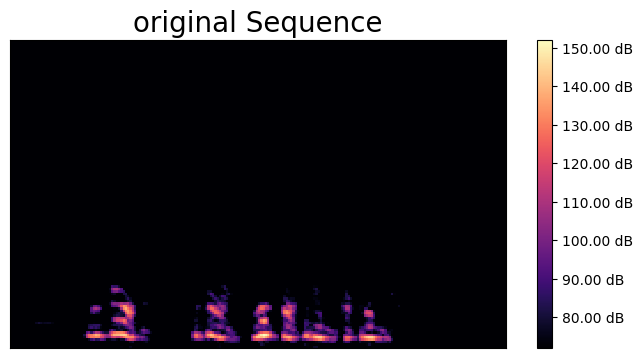

In [16]:
X=np.load('Neuro/spectrograms/jap_filter_mel_spectrograms/jap_filter_mel_spec_105.npy')
fig_ori, ax = plt.subplots(figsize=(8, 4))
img = librosa.display.specshow(X)
ax.set_title('original Sequence', fontsize=20)
fig_ori.colorbar(img, ax=ax, format=f'%0.2f dB')

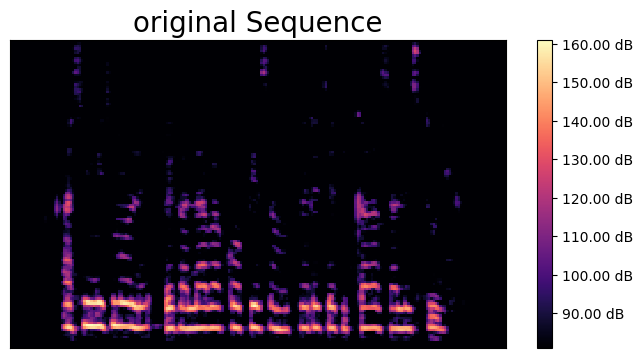

In [12]:
X=np.load('Neuro/spectrograms/esp_mel_spectrograms/esp_mel_spec_10.npy')
fig_ori, ax = plt.subplots(figsize=(8, 4))
img = librosa.display.specshow(X)
ax.set_title('original Sequence', fontsize=20)
fig_ori.colorbar(img, ax=ax, format=f'%0.2f dB')